# Cat-Not Cat Regonition using Logistic Regression as a Neural Network

Importing necessary libraries

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from datasets import load_dataset


c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining file paths for training and testing files

In [3]:
# Define file paths
train_file_path = r'C:\Users\Sahil\Desktop\Catnoncat\catvnoncat\train_catvnoncat.h5'
test_file_path = r'C:\Users\Sahil\Desktop\Catnoncat\catvnoncat\test_catvnoncat.h5'

In [4]:
# Load Training Data

with h5py.File(train_file_path , 'r') as train_file:
 print("The Keys in the training file:" , list(train_file.keys()))
 train_set_x_orig = train_file['train_set_x'][:]
 train_set_y = train_file['train_set_y'][:].reshape(train_set_x_orig.shape[0],1)

# Load the Testing Data

with h5py.File(test_file_path , 'r') as test_file:
 print("The keys in the testing file:" , list(test_file.keys()))

 test_set_x_orig = test_file['test_set_x'][:]
 test_set_y = test_file['test_set_y'][:].reshape(test_set_x_orig.shape[0] ,1)
 classes = test_file['list_classes'][:]


The Keys in the training file: ['list_classes', 'train_set_x', 'train_set_y']
The keys in the testing file: ['list_classes', 'test_set_x', 'test_set_y']


In [5]:
print("Train set X shape:" , train_set_x_orig.shape)
print("Train set Y shape:" , train_set_y.shape)
print("Test set X shape:" , test_set_x_orig.shape)
print("Test set Y shape:" , test_set_y.shape)
print(classes)
print(classes[0].decode('utf-8'))

Train set X shape: (209, 64, 64, 3)
Train set Y shape: (209, 1)
Test set X shape: (50, 64, 64, 3)
Test set Y shape: (50, 1)
[b'non-cat' b'cat']
non-cat


The label for the image is [0] which means that the image is: non-cat


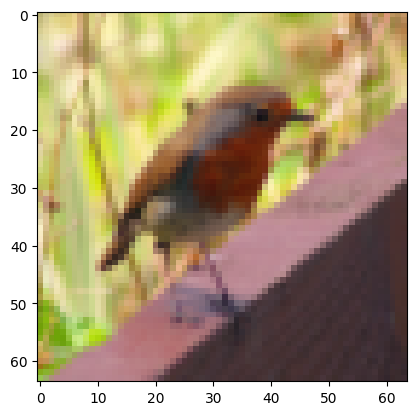

In [6]:
# Example of a picture

index = 10 
plt.imshow(train_set_x_orig[index])
print('The label for the image is', train_set_y[index] ,
       'which means that the image is:' , classes[np.squeeze(train_set_y[10])].decode('utf-8'))

In [7]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1] #height = width of image

print('Number of training data:' , m_train)
print('Number of test data:' , m_test)
print('The Height and Weight of each image in pixel:' , num_px)

Number of training data: 209
Number of test data: 50
The Height and Weight of each image in pixel: 64


In [8]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0] , -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0] , -1).T
train_set_y = train_set_y.T
test_set_y = test_set_y.T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


Standardizing Data

In [9]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

Building a Neural Network
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
   - Calculate current loss (forward propagation)
   - Calculate current gradient (backward propagation)
   - Update parameters (gradient descent)

Defining Sigmoid function

In [10]:
def sigmoid(z): 
 
 return 1/(1+np.exp(-z))

Initializing the parameters(weights and bias)

In [11]:
# Initializing the parameters

def initialize_with_zeros(dim):
 w = np.zeros(shape=(dim , 1))
 b = 0 

 #assert checks whether the condition meets or not, if it meets the flow continues where as if it doesnot then assertion error is displayed

 assert(w.shape == (dim,1))
 assert(isinstance(b,float) or isinstance(b,int))

 return w , b

Performing forward propagation and backwards propagation


In [12]:
def propagate(w , b , X , Y):

 m = X.shape[1]

 A = sigmoid(np.dot(w.T,X) + b)   

 cost = np.sum(((-np.log(A))*Y + (-np.log(1-A)*(1-Y)))/m)

 dw = (np.dot(X , (A-Y).T)) / m
 db = np.sum(A-Y) / m

 assert( dw.shape == w.shape)
 assert(db.dtype == float)

 cost = np.squeeze(cost)
 assert(cost.shape == ())

 grads = { 
  'dw' : dw,
  'db' : db
 }

 return grads , cost

Optimizing the parametes to reduce cost

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []  # Initialize costs as an empty list

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)  # Ensure cost is returned here

        dw = grads['dw']
        db = grads['db']

        # Update parameters
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)

        # Append cost to costs list
        if i % 100 == 0:
            costs.append(cost)  # Append the cost returned from propagate

        # Print the cost every 100 iterations if required
        if print_cost and i % 100 == 0:
            print('Cost after each iteration %i : %f' % (i, cost))

    # Parameters and gradients to return
    params = {
        'w': w,
        'b': b
    }
    
    grads = {
        'dw': dw,
        'db': db
    }

    return params, grads, costs  # Ensure return is outside of the for loop


Predicting function


In [14]:
def predict(w , b , X):

  m = X.shape[1]
  Y_prediction = np.zeros((1,m))
  w = w.reshape(X.shape[0] , 1)
  
  A = sigmoid(np.dot(w.T , X) + b) 

  Y_prediction = (A >= 0.5) * 1.0

  assert(Y_prediction.shape == (1,m))

  return Y_prediction

Creating a single Model that returns the optimized parameters and the costs for each iteration 

In [15]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):

 # Initialize the parameters with zeros 
 w , b = initialize_with_zeros(X_train.shape[0])

 # Gradient Descent
 parameters , grads , costs = optimize(w , b , X_train , Y_train , num_iterations , learning_rate)

 #Retrive parameters w and b from dictionary

 w = parameters['w']
 b = parameters['b']

 # Predict text/train set
 Y_prediction_test = predict(w,b,X_test)
 Y_prediction_train = predict(w , b , X_train)

 # Print train/test Errors
 print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
 print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

 d = {"costs": costs,
      "Y_prediction_test": Y_prediction_test, 
      "Y_prediction_train" : Y_prediction_train, 
      "w" : w, 
      "b" : b,
      "learning_rate" : learning_rate,
      "num_iterations": num_iterations}
    
 return d
 


In [16]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2500, learning_rate = 0.002, print_cost = False)


train accuracy: 96.65071770334929 %
test accuracy: 74.0 %


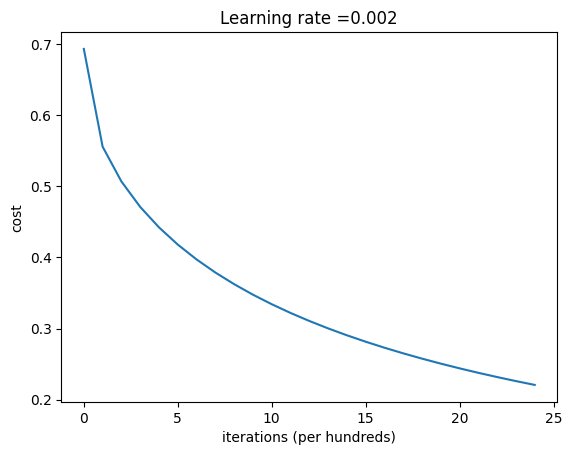

In [17]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Testing on Unseen images

Y-Predicted =  0.0 . So , This is a non-cat


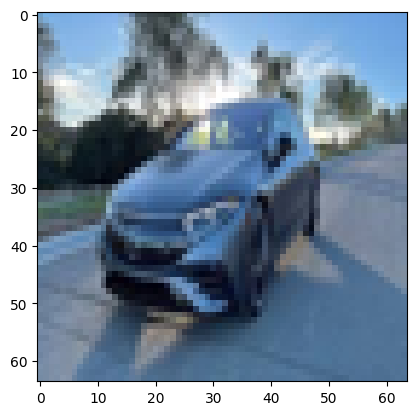

In [18]:
# Testing with your image

my_image = 'car.jpg'

fname = 'images/images/' + my_image
image = Image.open(fname)


#Re-sizing the image to match dimensions of training and testing image

resized_image = image.resize((num_px , num_px) , Image.BICUBIC)

# convert image into numpy array 

img = np.array(resized_image)

# normalize the images

img = img / 255

# Reshaping the image by flattening it

flat_img = img.reshape((1, num_px * num_px * 3)).T

# Importing optimized weight and bias 

opt_weight , opt_bias = d['w'] , d['b']

# Predicting the output

my_predicted_image = predict(opt_weight , opt_bias , flat_img)

plt.imshow(img)
print('Y-Predicted = ' , np.squeeze(my_predicted_image), '. So , This is a' , classes[int(np.squeeze(my_predicted_image).item())].decode('utf-8'))






Y-Predicted =  1.0 . So , This is a cat


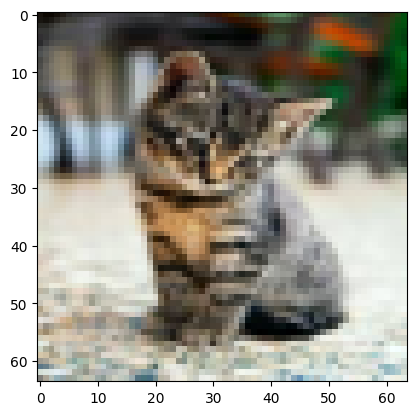

In [22]:
# Testing with your image

my_image = 'cat4.jpg'

fname = 'images/images/' + my_image
image = Image.open(fname)


#Re-sizing the image to match dimensions of training and testing image

resized_image = image.resize((num_px , num_px) , Image.BICUBIC)

# convert image into numpy array 

img = np.array(resized_image)

# normalize the images

img = img / 255

# Reshaping the image by flattening it

flat_img = img.reshape((1, num_px * num_px * 3)).T

# Importing optimized weight and bias 

opt_weight , opt_bias = d['w'] , d['b']

# Predicting the output

my_predicted_image = predict(opt_weight , opt_bias , flat_img)

plt.imshow(img)
print('Y-Predicted = ' , np.squeeze(my_predicted_image), '. So , This is a' , classes[int(np.squeeze(my_predicted_image).item())].decode('utf-8'))






Y-Predicted =  1.0 . So , This is a cat


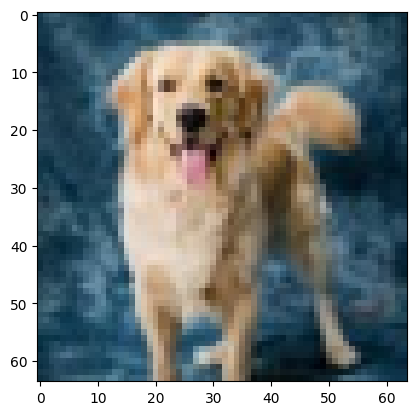

In [24]:
# Testing with your image

my_image = 'dog.jpg'

fname = 'images/images/' + my_image
image = Image.open(fname)


#Re-sizing the image to match dimensions of training and testing image

resized_image = image.resize((num_px , num_px) , Image.BICUBIC)

# convert image into numpy array 

img = np.array(resized_image)

# normalize the images

img = img / 255

# Reshaping the image by flattening it

flat_img = img.reshape((1, num_px * num_px * 3)).T

# Importing optimized weight and bias 

opt_weight , opt_bias = d['w'] , d['b']

# Predicting the output

my_predicted_image = predict(opt_weight , opt_bias , flat_img)

plt.imshow(img)
print('Y-Predicted = ' , np.squeeze(my_predicted_image), '. So , This is a' , classes[int(np.squeeze(my_predicted_image).item())].decode('utf-8'))




